# **Malaria Detection**

##<b>Problem Definition</b>
**The context:** <br>
Malaria is a serious infectious disease caused by Plasmodium parasites, spread through the bites of infected female Anopheles mosquitoes.
It remains a major health challenge in many parts of the world, especially in sub-Saharan Africa, Southeast Asia, and Latin America. The disease is particularly dangerous for young children and pregnant women, who face a higher risk of severe illness. Even though it’s preventable and treatable, limited access to early diagnosis and proper care makes it difficult to control in high-risk regions.<br>
Although microscopic examination of blood smears is the current gold standard for malaria diagnosis, it is time-consuming, requires trained specialists, and is prone to human error.
Therefore, developing automated and accurate detection methods is essential to improve diagnostic efficiency and support timely treatment, particularly in resource-limited settings.<br>
<br>
**The objectives:**<br>
The main objective of this project is to build a deep learning model that can accurately detect malaria-infected cells from microscopic blood images, making the diagnostic process faster and more reliable.<br>
<br>
**The key questions:** <br>
- Can a deep learning model accurately distinguish between parasitized and uninfected blood cells using microscopic images?<br>
- How does the performance of a custom CNN model compare to that of a pre-trained model such as VGG16?<br>
- What level of accuracy and generalization can be achieved using data augmentation techniques on a relatively small dataset?<br>
- How effectively does the model generalize to unseen data, and how can overfitting be minimized during training?
- Which image features (color, shape, texture) are most relevant to the model’s decision-making process?
<br>

**The problem formulation:**<br>
We are applying data science to automate the detection of malaria from microscopic blood images, replacing the traditional manual process that is often slow, subjective, and dependent on skilled experts.
By building a reliable image classification model, we aim to support faster and more consistent diagnoses.<br>
<br>
## <b>Data Description </b>

There are a total of 24,958 train and 2,600 test images (colored) that we have taken from microscopic images. These images are of the following categories:<br>


**Parasitized:** The parasitized cells contain the Plasmodium parasite which causes malaria<br>
**Uninfected:** The uninfected cells are free of the Plasmodium parasites<br>


###<b> Mount the Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### <b>Loading libraries</b>

In [ ]:
import tensorflow as tf
import zipfile
import os
import numpy as np
import pandas as pd
import cv2

from tensorflow import keras
from tensorflow.keras import backend
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import random

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns
import warnings


warnings.filterwarnings('ignore')

### <b>Let us load the data</b>

**Note:**
- You must download the dataset from the link provided on Olympus and upload the same to your Google Drive. Then unzip the folder.

In [ ]:
zip_path = '/content/drive/MyDrive/Data Science/Capstone Project/cell_images.zip'
extract_path = 'malaria_data'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("Extraced in :", extract_path)

Extraced in : malaria_data


The extracted folder has different folders for train and test data will contain the different sizes of images for parasitized and uninfected cells within the respective folder name.

The size of all images must be the same and should be converted to 4D arrays so that they can be used as an input for the convolutional neural network. Also, we need to create the labels for both types of images to be able to train and test the model.

Let's do the same for the training data first and then we will use the same code for the test data as well.

In [ ]:
data_path = 'malaria_data/cell_images/train'
total_images = sum(len(files) for _, _, files in os.walk(data_path))
print("The total number of images:", total_images)

The total number of images: 24958


In [ ]:
datagen_train = ImageDataGenerator()

generator_train = datagen_train.flow_from_directory(
    'malaria_data/cell_images/train',
    target_size=(64, 64),
    batch_size=25000,
    class_mode='binary',
    shuffle=False
)

X_train, y_train = next(generator_train)
y_train = (1 - y_train).astype(int)

Found 24958 images belonging to 2 classes.


In [ ]:
datagen_test = ImageDataGenerator()

generator_test = datagen_test.flow_from_directory(
    'malaria_data/cell_images/test',
    target_size=(64, 64),
    batch_size=25000,
    class_mode='binary',
    shuffle=False
)

X_test, y_test = next(generator_test)
y_test = (1 - y_test).astype(int)

Found 2600 images belonging to 2 classes.


###<b> Check the shape of train and test images

In [ ]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (24958, 64, 64, 3)
X_test shape: (2600, 64, 64, 3)


###<b> Check the shape of train and test labels

In [ ]:
print("y_train label shape:", y_train.shape)
print("y_train samples =", y_train[:5])
print(generator_train.filenames[:5])
print("y_test label shape:", y_test.shape)
print("y_test samples =", y_test[:5])
print(generator_test.filenames[:5])

y_train label shape: (24958,)
y_train samples = [1 1 1 1 1]
['parasitized/C100P61ThinF_IMG_20150918_144104_cell_162.png', 'parasitized/C100P61ThinF_IMG_20150918_144104_cell_163.png', 'parasitized/C100P61ThinF_IMG_20150918_144104_cell_164.png', 'parasitized/C100P61ThinF_IMG_20150918_144104_cell_165.png', 'parasitized/C100P61ThinF_IMG_20150918_144104_cell_167.png']
y_test label shape: (2600,)
y_test samples = [1 1 1 1 1]
['parasitized/C39P4thinF_original_IMG_20150622_105253_cell_105.png', 'parasitized/C39P4thinF_original_IMG_20150622_105253_cell_106.png', 'parasitized/C39P4thinF_original_IMG_20150622_105253_cell_107.png', 'parasitized/C39P4thinF_original_IMG_20150622_105253_cell_108.png', 'parasitized/C39P4thinF_original_IMG_20150622_105253_cell_109.png']


####<b><font color='1a82ff'> Observations and insights:</b>
- The total number of train and test images is 24,958 and 2,600 respectively, including samples from two categories: parasitized and uninfected.

- With the ImageDataGenerator function, the data is automatically loaded as 3-channel RGB images.

- Since each train and test image has a different size, all images are resized to 64 × 64 during data loading.

- Originally, the y-labels were defined as 0 for parasitized and 1 for uninfected. In this instance, however, the labels are inverted, with 0 representing uninfected and 1 representing parasitized.

### <b>Check the minimum and maximum range of pixel values for train and test images

In [ ]:
print(f"X_train max: {X_train.max()}, X_train min: {X_train.min()}")
print(f"X_test max: {X_test.max()}, X_test min: {X_test.min()}")

X_train max: 255.0, X_train min: 0.0
X_test max: 255.0, X_test min: 0.0


####<b><font color='1a82ff'> Observations and insights:</b>
- The pixel values in both the training and test sets range from 0 to 255.

###<b> Count the number of values in both uninfected and parasitized

In [ ]:
counts = pd.Series(y_train).value_counts()
print(f"Class Counts of the train dataset: \nUninfected (0): {counts[0]} \nParasitized (1): {counts[1]}")
print('--'*30)
counts = pd.Series(y_test).value_counts()
print(f"Class Counts of the test dataset: \nUninfected (0): {counts[0]} \nParasitized (1): {counts[1]}")

Class Counts of the train dataset: 
Uninfected (0): 12376 
Parasitized (1): 12582
------------------------------------------------------------
Class Counts of the test dataset: 
Uninfected (0): 1300 
Parasitized (1): 1300


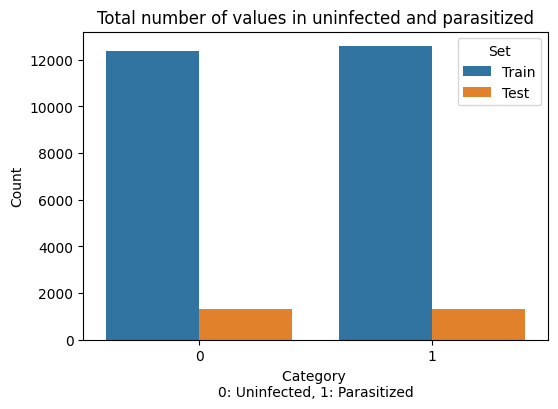

In [ ]:
train_df = pd.DataFrame({'Label': y_train, 'Set': 'Train'})
test_df = pd.DataFrame({'Label': y_test, 'Set': 'Test'})

combined_df = pd.concat([train_df, test_df])

plt.figure(figsize=(6, 4))
sns.countplot(data=combined_df, x='Label', hue='Set')
plt.title("Total number of values in uninfected and parasitized")
plt.xlabel("Category \n0: Uninfected, 1: Parasitized")
plt.ylabel("Count")
plt.show()

####<b><font color='1a82ff'> Observations and insights:</b>
- The training and test datasets are almost equally distributed across both categories, indicating that the datasets are balanced.

###<b>Normalize the images

In [ ]:
X_train = X_train / 255.0
X_test = X_test / 255.0

###<b> Plot to check if the data is balanced

In [ ]:
print("Min pixel value of train images:", X_train.min())
print("Max pixel value of train images:", X_train.max())
print("Mean pixel value of train images:", X_train.mean())
print("Min pixel value of test images:", X_test.min())
print("Max pixel value of test images:", X_test.max())
print("Mean pixel value of test images:", X_test.mean())

Min pixel value of train images: 0.0
Max pixel value of train images: 1.0
Mean pixel value of train images: 0.47042766
Min pixel value of test images: 0.0
Max pixel value of test images: 1.0
Mean pixel value of test images: 0.45204183


####<b><font color='1a82ff'> Observations and insights:</b>
- Both datasets are normalized to a range between 0 and 1.




### <b>Data Exploration</b>
Let's visualize the images from the train data

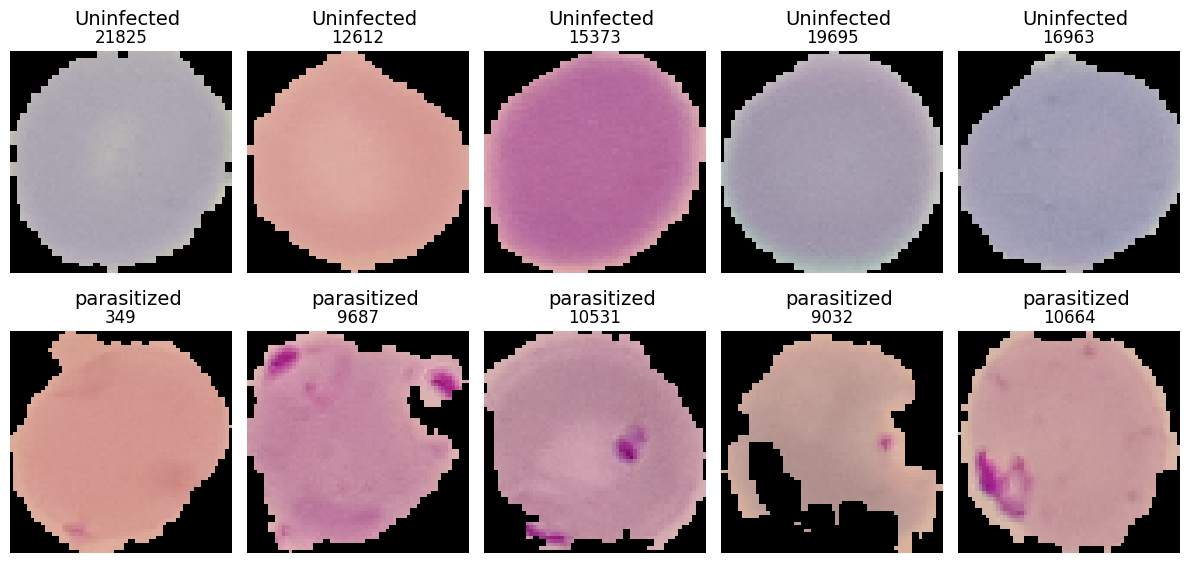

In [ ]:
uninfected_indices = np.random.choice(np.where(y_train == 0)[0], size=5, replace=False)
parasitized_indices = np.random.choice(np.where(y_train == 1)[0], size=5, replace=False)

plt.figure(figsize=(12, 6))

for i, idx in enumerate(uninfected_indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[idx])
    plt.text(18, -8, 'Uninfected', fontsize = 14)
    plt.title(idx)
    plt.axis('off')

for i, idx in enumerate(parasitized_indices):
    plt.subplot(2, 5, i + 6)
    plt.imshow(X_train[idx])
    plt.text(18, -8, 'parasitized', fontsize = 14)
    plt.title(idx)
    plt.axis('off')

plt.tight_layout()
plt.show()

####<b> <font color = '1a82ff'>Observations and insights:</b>
- 5 uninfected and 5 parasitized image data were randomly selected and plotted with their number.

###<b> Visualize the images with subplot(6, 6) and figsize = (12, 12)

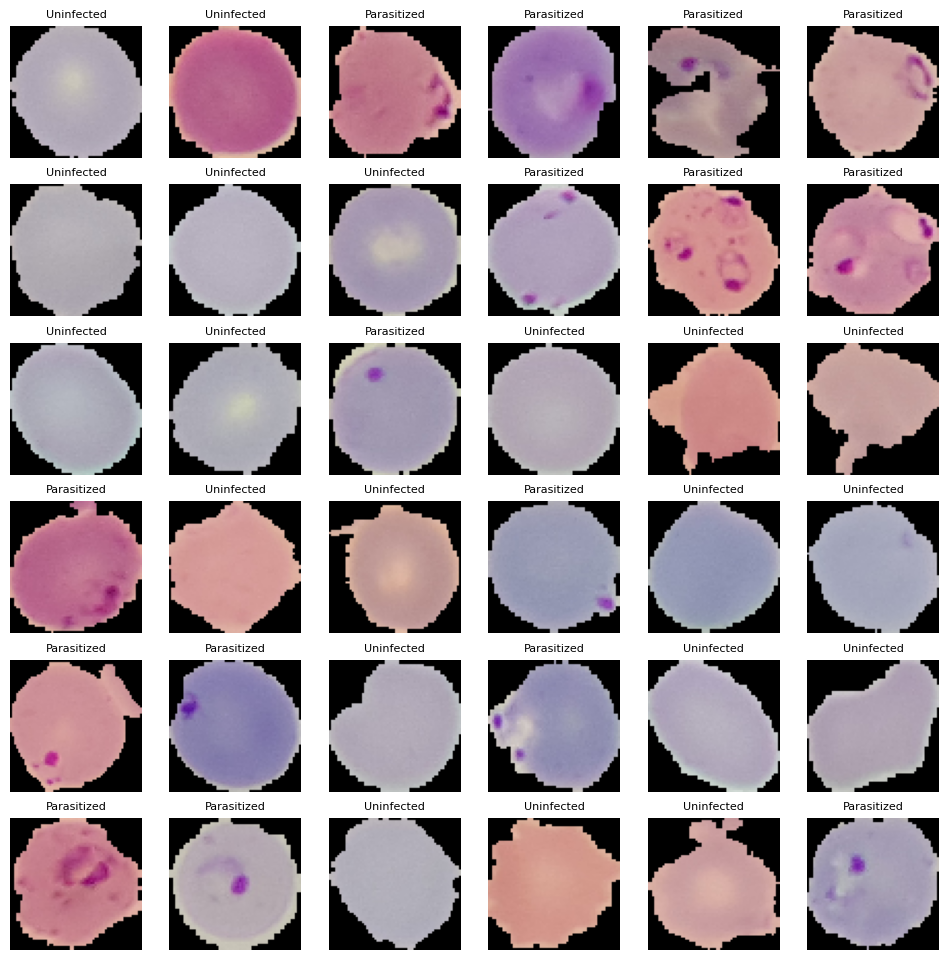

In [ ]:
plt.figure(figsize=(12, 12))
random_indices = np.random.choice(len(X_train), size=36, replace=False)

for i, idx in enumerate(random_indices):
    plt.subplot(6, 6, i + 1)
    plt.imshow(X_train[idx])
    if y_train[idx] == 0:
        label = "Uninfected"
    else:
        label = "Parasitized"
    plt.title(label, fontsize=8)
    plt.axis('off')

plt.show()

####<font color = '1a82ff'><b>Observations and insights:</b>
- A total of 36 parasitized and uninfected images were randomly selected and plotted along with their corresponding labels.

- all images are transformed to the same size.

- In the parasitized images, purple-stained regions are visible, indicating the presence of parasites.


###<b> Plotting the mean images for parasitized and uninfected

In [ ]:
uninfected_mask = y_train == 0
parasitized_mask = y_train == 1

mean_uninfected = X_train[uninfected_mask].mean(axis=0)
mean_parasitized = X_train[parasitized_mask].mean(axis=0)

<b> Mean image for parasitized

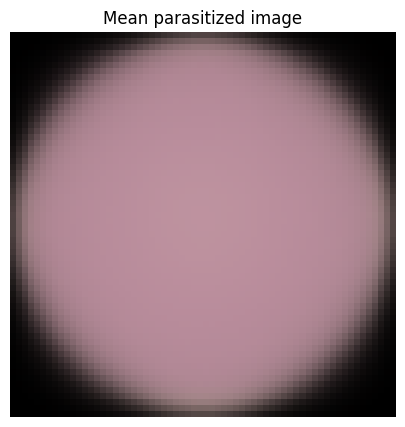

In [ ]:
plt.figure(figsize=(10, 5))
plt.imshow(mean_parasitized)
plt.title("Mean parasitized image")
plt.axis('off')
plt.show()

<b> Mean image for uninfected

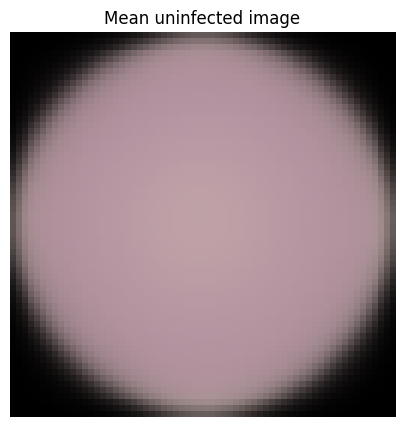

In [ ]:
plt.figure(figsize=(10, 5))
plt.imshow(mean_uninfected)
plt.title("Mean uninfected image")
plt.axis('off')
plt.show()

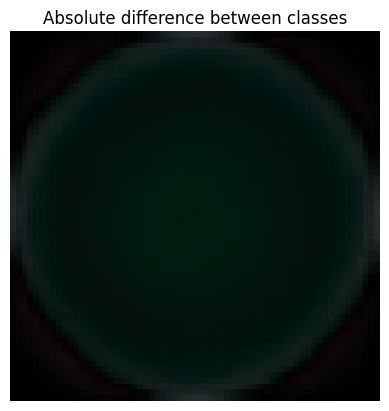

In [ ]:
diff = np.abs(mean_parasitized - mean_uninfected)

plt.imshow(diff*2)
plt.title("Absolute difference between classes")
plt.axis('off')
plt.show()

####<b><font color='1a82ff'>Observations and insights:</b>
- The training images are generally darker compared to the uninfected images, based on their average pixel values.

- When the absolute difference between classes is amplified, brighter regions are observed around both the boundary and the center. This indicates that noticeable differences exist in these areas between parasitized and uninfected cells.



### <b>Converting RGB to HSV of Images using OpenCV

###<b> Converting the train data

In [ ]:
def image_hsv(dataset):

    hue_array = []
    sat_array = []
    val_array = []

    for i, image in enumerate(dataset):
        img_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        hue, sat, val = cv2.split(img_hsv)
        hue_array.append(hue)
        sat_array.append(sat)
        val_array.append(val)

    return hue_array, sat_array, val_array

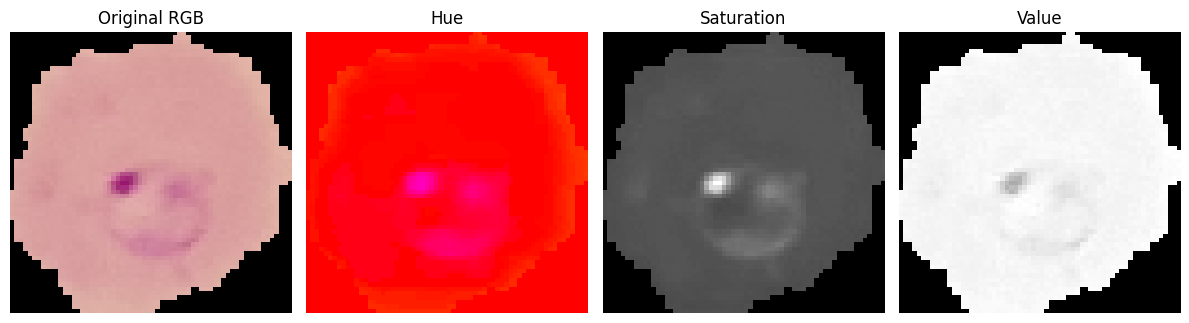

In [ ]:
hsv_train = image_hsv(X_train)
plt.figure(figsize=(12, 6))

plt.subplot(1, 4, 1)
plt.imshow(X_train[0])
plt.title("Original RGB")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(hsv_train[0][0], cmap='hsv')
plt.title("Hue")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(hsv_train[1][0], cmap='gray')
plt.title("Saturation")
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(hsv_train[2][0], cmap='gray')
plt.title("Value")
plt.axis('off')

plt.tight_layout()
plt.show()

###<b> Converting the test data

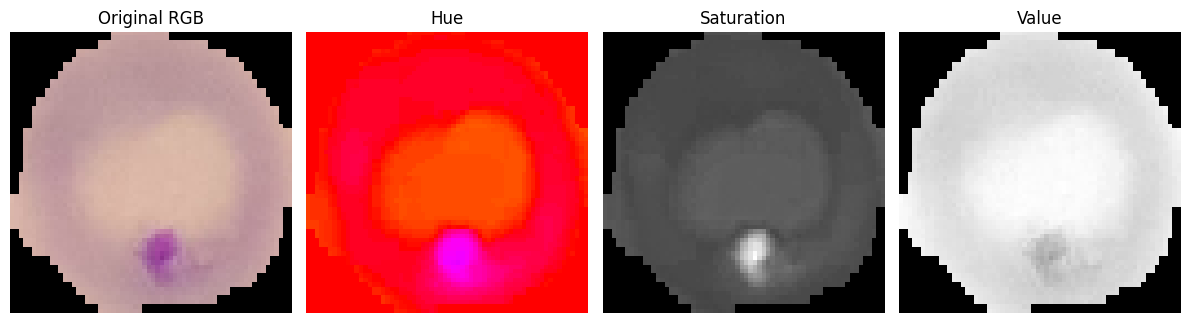

In [ ]:
hsv_test = image_hsv(X_test)
plt.figure(figsize=(12, 6))

plt.subplot(1, 4, 1)
plt.imshow(X_test[0])
plt.title("Original RGB")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(hsv_test[0][0], cmap='hsv')
plt.title("Hue")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(hsv_test[1][0], cmap='gray')
plt.title("Saturation")
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(hsv_test[2][0], cmap='gray')
plt.title("Value")
plt.axis('off')

plt.tight_layout()
plt.show()

####<b><font color='1a82ff'>Observations and insights:</b>
- All training and testing images were converted into their respective Hue, Saturation, and Value (HSV) channels for further analysis.

- The HSV decomposition of the parasitized cell image reveals that the infected region appears prominently in the Hue and Saturation channels.

- The hue channel emphasizes color differences, highlighting the infected area, while the saturation channel shows the intensity of color, making the parasitic region more distinct.

- The value channel captures the brightness but provides less contrast for infection-specific features.

###<b> Processing Images using Gaussian Blurring

###<b> Gaussian Blurring on train data

In [ ]:
def gaussian_blurring(dataset):
    train_blurred= []

    for i, image in enumerate(dataset):
        train_blurred.append(cv2.GaussianBlur(image, (5, 5), 0))
    return train_blurred

(np.float64(-0.5), np.float64(63.5), np.float64(63.5), np.float64(-0.5))

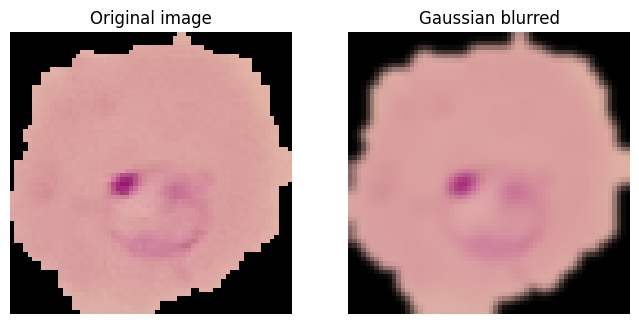

In [ ]:
plt.figure(figsize=(8, 6))

plt.subplot(1, 2, 1)
plt.imshow(X_train[0])
plt.title("Original image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(gaussian_blurring(X_train)[0])
plt.title("Gaussian blurred")
plt.axis('off')

###<b> Gaussian Blurring on test data

(np.float64(-0.5), np.float64(63.5), np.float64(63.5), np.float64(-0.5))

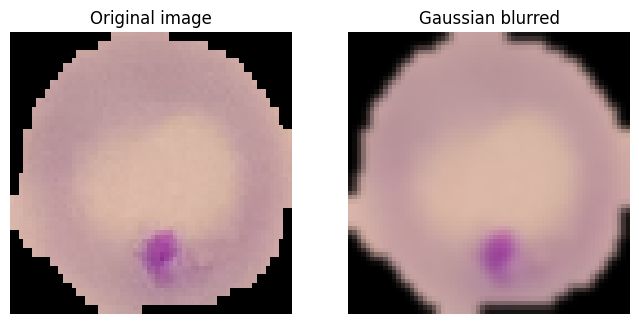

In [ ]:
plt.figure(figsize=(8, 6))

plt.subplot(1, 2, 1)
plt.imshow(X_test[0])
plt.title("Original image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(gaussian_blurring(X_test)[0])
plt.title("Gaussian blurred")
plt.axis('off')

####<b><font color='1a82ff'>**Observations and insights:</b>
- The train and test images are blurred with the 5 × 5 gaussian filter.

- While blurring can help reduce noise, it is likely to be ineffective for malaria detection, as it may obscure the fine structural and color differences that are critical for identifying parasitized cells.

- Initially, classification models can be developed based only on HSV-decomposed images, without applying Gaussian blurring.

- Contrast enhancement or edge enhancement can also be considered to improve the performance of classification models.





## **Model Building**

### **ANN Base Model**

**Note:** The Base Model has been fully built and evaluated with all outputs shown to give an idea about the process of the creation and evaluation of the performance of a CNN architecture. A similar process can be followed in iterating to build better-performing CNN architectures.

###<b> Importing the required libraries for building and training our Model

In [ ]:
backend.clear_session()
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

####<B>One Hot Encoding the train and test labels

In [ ]:
y_train_encoding = keras.utils.to_categorical(y_train, num_classes=len(np.unique(y_train)))
y_test_encoding = keras.utils.to_categorical(y_test, num_classes=len(np.unique(y_test)))

In [ ]:
print('y_train shape:', y_train_encoding.shape)
print('y_test shape:', y_test_encoding.shape)
print('--'*30)
print('y_train samples:', y_train_encoding[:5])
print('y_test samples:', y_test_encoding[:5])

y_train shape: (24958, 2)
y_test shape: (2600, 2)
------------------------------------------------------------
y_train samples: [[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
y_test samples: [[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


###<b> Building the model

In [ ]:
def ann_model():
    model = Sequential()

    model.add(Flatten(input_shape=(64, 64, 3)))

    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(2, activation='softmax'))

    return model

###<b> Compiling the model

In [ ]:
ann_model = ann_model()
ann_model.compile(loss = 'categorical_crossentropy', optimizer = keras.optimizers.Adam(learning_rate = 0.001), metrics = ['accuracy'])
ann_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)                  │ (None, 12288)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │       6,291,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,456,450 (24.63 MB)

 Trainable params: 6,456,450 (24.63 MB)

 Non-trainable params: 0 (0.00 B)

<b> Using Callbacks

In [ ]:
callbacks_ann = [EarlyStopping(monitor = 'val_loss', patience = 4), ModelCheckpoint('best_ann.keras', monitor = 'val_loss', save_best_only = True)]

<b> Fit and train our Model

In [ ]:
ann_history = ann_model.fit(X_train,  y_train_encoding, callbacks = callbacks_ann, validation_split=0.2, epochs=20, batch_size=128, verbose=1)

Epoch 1/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.5641 - loss: 1.2591 - val_accuracy: 0.0000e+00 - val_loss: 0.9420
Epoch 2/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.6310 - loss: 0.6416 - val_accuracy: 0.0000e+00 - val_loss: 1.0682
Epoch 3/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6278 - loss: 0.6374 - val_accuracy: 0.0000e+00 - val_loss: 1.2630
Epoch 4/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6278 - loss: 0.6358 - val_accuracy: 0.0000e+00 - val_loss: 0.9444
Epoch 5/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.6278 - loss: 0.6218 - val_accuracy: 0.0000e+00 - val_loss: 0.9302
Epoch 6/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6278 - loss: 0.6255 - val_accuracy: 0.0000e+00 - val_loss: 0.9081
Epoch 7/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6278 - loss: 0.6229 - val_accuracy: 0.0000e+00 - val_loss: 0.8608
Epoch 8/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6278 -

###<b> Evaluating the model on test data

In [ ]:
loss, accuracy = ann_model.evaluate(X_test, y_test_encoding, verbose=1)
print(f"Test Accuracy: {accuracy:.4f}")

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8362 - loss: 0.5778
Test Accuracy: 0.5000


<b>Plotting the train and validation curves

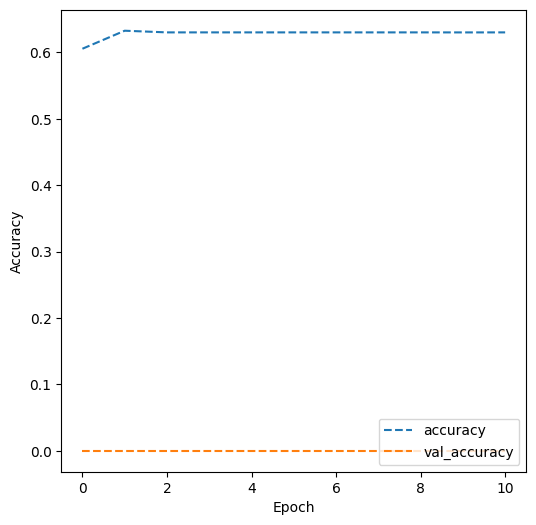

In [ ]:
plt.figure(figsize = (6, 6))
plt.plot(ann_history.history['accuracy'], '--', label='accuracy')
plt.plot(ann_history.history['val_accuracy'], '--', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

<b> Plotting the confusion matrix

In [ ]:
y_pred_probs = ann_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_encoding, axis=1)

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1300
           1       0.50      1.00      0.67      1300

    accuracy                           0.50      2600
   macro avg       0.25      0.50      0.33      2600
weighted avg       0.25      0.50      0.33      2600



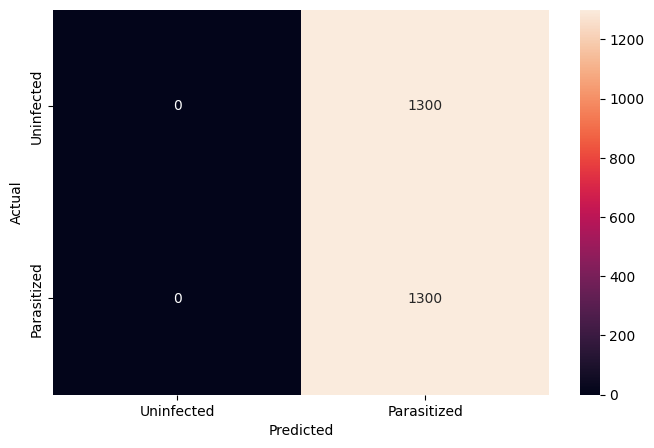

In [ ]:
print(classification_report(y_true, y_pred))
cm = confusion_matrix(y_true, y_pred)
class_names = range(0, 1)
plt.figure(figsize = (8, 5))
sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['Uninfected', 'Parasitized'], yticklabels = ['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

####<b><font color='1a82ff'> Observations and insights:</b>
- The ANN model was built using four dense layers and trained with early stopping callbacks (patience=4).

- Upon evaluation, the model achieved a test accuracy of 50%, which indicates that it fails to generalize to unseen data.

- In the accuracy plot, the training accuracy plateaus around 60%, while the validation accuracy remains consistently at 0%.

- This suggests that the model is unable to learn meaningful patterns from the data and is likely predicting only a single class.

- The confusion matrix shows that the model predicts every image as parasitized, completely failing to identify uninfected cases.

- Overall, the ANN model underperforms due to its inability to capture spatial features inherent in image data.

###**CNN Base Model**###

In [ ]:
backend.clear_session()
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
def cnn_base_model():
    model = Sequential()

    model.add(Conv2D(filters = 32, kernel_size = 2, padding = "same", activation = "relu", input_shape = (64, 64, 3)))
    model.add(MaxPooling2D(pool_size = 2))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters = 64, kernel_size = 2, padding = "same", activation = "relu"))
    model.add(MaxPooling2D(pool_size = 2))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters = 128, kernel_size = 2, padding = "same", activation = "relu"))
    model.add(MaxPooling2D(pool_size = 2))
    model.add(Dropout(0.2))

    model.add(Flatten())

    model.add(Dense(512, activation = "relu"))
    model.add(Dropout(0.4))
    model.add(Dense(2, activation = "softmax"))

    model.summary()
    return model

In [ ]:
cnn_base_model = cnn_base_model()
cnn_base_model.compile(loss = 'categorical_crossentropy', optimizer = keras.optimizers.Adam(learning_rate = 0.001), metrics = ['accuracy'])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 32)          │             416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 128)         │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       4,194,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,237,410 (16.16 MB)

 Trainable params: 4,237,410 (16.16 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
callbacks_cnn = [EarlyStopping(monitor = 'val_loss', patience = 4), ModelCheckpoint('best_cnn.keras', monitor = 'val_loss', save_best_only = True)]

In [ ]:
cnn_base_history = cnn_base_model.fit(X_train,  y_train_encoding, callbacks = callbacks_cnn, validation_split=0.2, epochs=30, batch_size=128, verbose=1)

Epoch 1/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 18s 67ms/step - accuracy: 0.6217 - loss: 0.7099 - val_accuracy: 0.8429 - val_loss: 0.6467
Epoch 2/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.8783 - loss: 0.3484 - val_accuracy: 0.9489 - val_loss: 0.1652
Epoch 3/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9603 - loss: 0.1141 - val_accuracy: 0.9808 - val_loss: 0.1028
Epoch 4/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.9716 - loss: 0.0884 - val_accuracy: 0.9814 - val_loss: 0.0843
Epoch 5/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9765 - loss: 0.0745 - val_accuracy: 0.9762 - val_loss: 0.1102
Epoch 6/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9775 - loss: 0.0686 - val_accuracy: 0.9792 - val_loss: 0.1028
Epoch 7/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9782 - loss: 0.0669 - val_accuracy: 0.9784 - val_loss: 0.1042
Epoch 8/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9797 - loss: 0.0619 - val_acc

In [ ]:
loss, accuracy = cnn_base_model.evaluate(X_test, y_test_encoding, verbose=1)
print(f"Test Accuracy: {accuracy:.4f}")

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9760 - loss: 0.0663
Test Accuracy: 0.9777


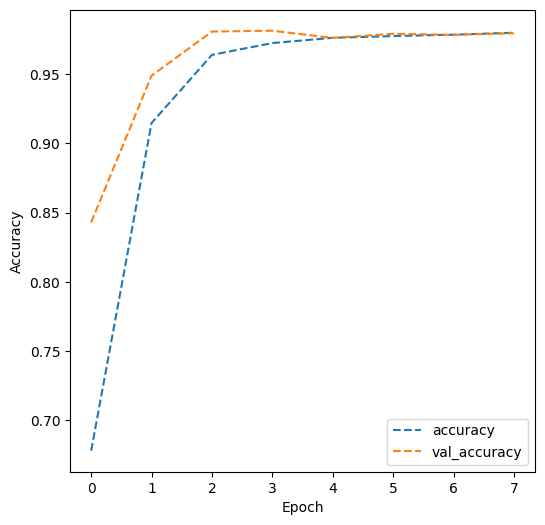

In [ ]:
plt.figure(figsize = (6, 6))
plt.plot(cnn_base_history.history['accuracy'], '--', label='accuracy')
plt.plot(cnn_base_history.history['val_accuracy'], '--', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
y_pred_probs = cnn_base_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_encoding, axis=1)

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1300
           1       0.98      0.98      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



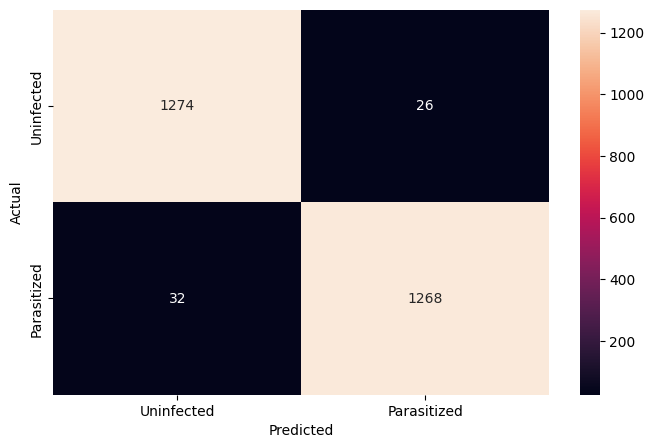

In [ ]:
print(classification_report(y_true, y_pred))
cm = confusion_matrix(y_true, y_pred)
class_names = range(0, 1)
plt.figure(figsize = (8, 5))
sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['Uninfected', 'Parasitized'], yticklabels = ['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

####<b><font color='1a82ff'> Observations and insights:</b>
- The first CNN model consists of 13 layers, including 3 convolutional layers with ReLU activation function, 3 max pooling layers, 4 dropout layers, 1 flatten layer, and 2 dense layers. Early stopping was applied with a patience of 4.

- The model achieved a test accuracy of approximately 97.8%.

- Training accuracy steadily increased during the first few epochs and plateaued around 97% starting from epoch 5.

- Validation accuracy also increased rapidly at the beginning, showed slight fluctuation, and stabilized around 97% from epoch 4.

- No significant overfitting was observed, as both training and validation accuracies are closely aligned.

- The confusion matrix confirms the model's robustness, with only 58 misclassified samples out of 2600, resulting in an overall accuracy of 98%.

So now let's try to build another model with few more add on layers and try to check if we can try to improve the model. Therefore try to build a model by adding few layers if required and altering the activation functions.

###<b> Model 1
####<b> Trying to improve the performance of our model by adding new layers


In [ ]:
backend.clear_session()
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

###<b> Building the Model

In [ ]:
def cnn_model_1():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(64, 64, 3)))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(2, activation='softmax'))

    model.summary()

    return model

###<b> Compiling the model

In [ ]:
cnn_model_1 = cnn_model_1()
cnn_model_1.compile(loss = 'categorical_crossentropy', optimizer = keras.optimizers.Adam(learning_rate = 0.001), metrics = ['accuracy'])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,487,106 (9.49 MB)

 Trainable params: 2,487,106 (9.49 MB)

 Non-trainable params: 0 (0.00 B)

<b> Using Callbacks

In [ ]:
callbacks_cnn1 = [EarlyStopping(monitor = 'val_loss', patience = 4),
             ModelCheckpoint('best_cnn1.keras', monitor = 'val_loss', save_best_only = True)]

<b>Fit and Train the model

In [ ]:
cnn_history_1 = cnn_model_1.fit(X_train,  y_train_encoding, callbacks = callbacks_cnn1, validation_split=0.2, epochs=30, batch_size=128, verbose=1)

Epoch 1/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 22s 88ms/step - accuracy: 0.6309 - loss: 0.6307 - val_accuracy: 0.9854 - val_loss: 0.1601
Epoch 2/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9617 - loss: 0.1229 - val_accuracy: 0.9886 - val_loss: 0.0658
Epoch 3/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9717 - loss: 0.0814 - val_accuracy: 0.9798 - val_loss: 0.0803
Epoch 4/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9786 - loss: 0.0664 - val_accuracy: 0.9760 - val_loss: 0.0787
Epoch 5/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.9790 - loss: 0.0646 - val_accuracy: 0.9710 - val_loss: 0.0887
Epoch 6/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.9804 - loss: 0.0587 - val_accuracy: 0.9704 - val_loss: 0.0822


###<b> Evaluating the model

In [ ]:
loss, accuracy = cnn_model_1.evaluate(X_test, y_test_encoding, verbose=1)
print(f"Test Accuracy: {accuracy:.4f}")

82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9811 - loss: 0.0468
Test Accuracy: 0.9796


<b> Plotting the train and the validation curves

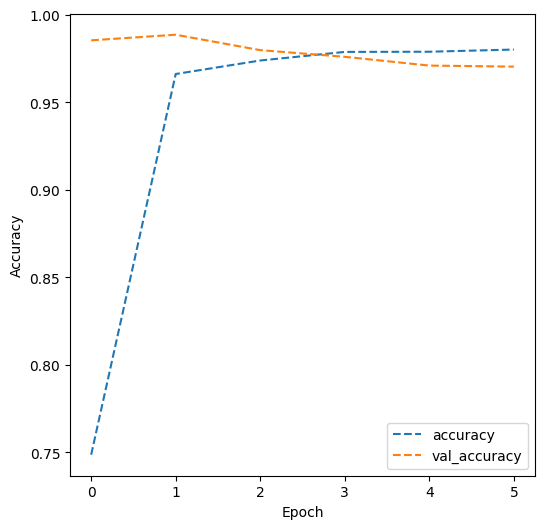

In [ ]:
plt.figure(figsize = (6, 6))
plt.plot(cnn_history_1.history['accuracy'], '--', label='accuracy')
plt.plot(cnn_history_1.history['val_accuracy'], '--', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

<b> Plotting the confusion matrix

In [ ]:
y_pred_probs = cnn_model_1.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_encoding, axis=1)

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1300
           1       0.97      0.99      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



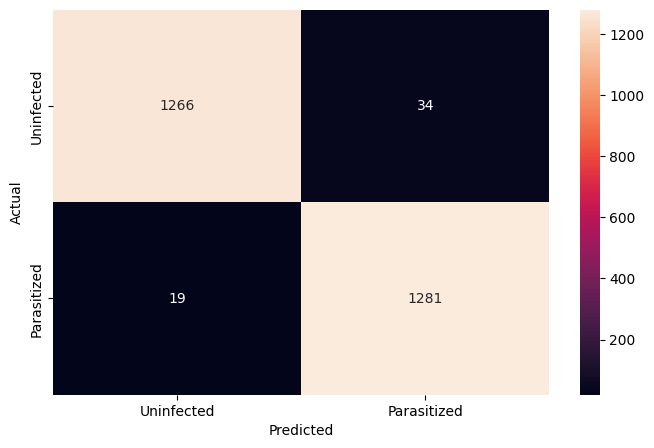

In [ ]:
print(classification_report(y_true, y_pred))
cm = confusion_matrix(y_true, y_pred)
class_names = range(0, 1)
plt.figure(figsize = (8, 5))
sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['Uninfected', 'Parasitized'], yticklabels = ['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

####<b><font color='1a82ff'> Observations and insights:</b>
- To build the second CNN model, an additional convolutional block (Conv2D → MaxPooling → Dropout) was added to the structure of the first CNN model.

- The training accuracy increased rapidly during the first epoch, then improved gradually until epoch 3, after which it stabilized around 97%.

- The validation accuracy started at approximately 98%, then decreased slightly and plateaued around 96%.

- From epoch 3 onward, a slight overfitting trend was observed, as training and validation accuracies began to diverge.

- The test accuracy achieved by this model is approximately 97.9%.
- Based on the confusion matrix, the overall accuracy remains 98%, with only 53 misclassified samples out of 2600.

- The second CNN model added an extra convolutional block, resulting in a slight improvement in performance, but it also introduced increased complexity and minor overfitting.

###<b>Think about it:</b><br>
Now let's build a model with LeakyRelu as the activation function  

*  Can the model performance be improved if we change our activation function to LeakyRelu?
*  Can BatchNormalization improve our model?

Let us try to build a model using BatchNormalization and using LeakyRelu as our activation function.

###<b> Model 2 with Batch Normalization

In [ ]:
backend.clear_session()
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

###<b> Building the Model

In [ ]:
def cnn_model_2():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=3, padding='same', input_shape=(64, 64, 3)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=64, kernel_size=3, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=128, kernel_size=3, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=256, kernel_size=3, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(2, activation='softmax'))

    model.summary()

    return model

###<b>Compiling the model

In [ ]:
cnn_model_2 = cnn_model_2()
cnn_model_2.compile(loss = 'categorical_crossentropy', optimizer = keras.optimizers.Adam(learning_rate = 0.0001), metrics = ['accuracy'])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             

 Total params: 2,489,026 (9.49 MB)

 Trainable params: 2,488,066 (9.49 MB)

 Non-trainable params: 960 (3.75 KB)

<b> Using callbacks

In [ ]:
callbacks_cnn2 = [EarlyStopping(monitor = 'val_loss', patience = 5), ModelCheckpoint('best_cnn2.keras', monitor = 'val_loss', save_best_only = True)]

<b>Fit and train the model

In [ ]:
cnn_history_2 = cnn_model_2.fit(X_train, y_train_encoding, validation_split=0.2, callbacks = callbacks_cnn2, epochs=50, batch_size=128, verbose=1)

Epoch 1/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 25s 84ms/step - accuracy: 0.6053 - loss: 0.9176 - val_accuracy: 1.0000 - val_loss: 0.2577
Epoch 2/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 24s 29ms/step - accuracy: 0.7067 - loss: 0.5688 - val_accuracy: 1.0000 - val_loss: 0.0510
Epoch 3/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.7647 - loss: 0.4971 - val_accuracy: 0.9866 - val_loss: 0.0231
Epoch 4/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.8557 - loss: 0.3353 - val_accuracy: 0.9986 - val_loss: 0.0122
Epoch 5/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9210 - loss: 0.2049 - val_accuracy: 0.9936 - val_loss: 0.0253
Epoch 6/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9413 - loss: 0.1591 - val_accuracy: 0.9972 - val_loss: 0.0157
Epoch 7/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.9494 - loss: 0.1336 - val_accuracy: 0.9982 - val_loss: 0.0101
Epoch 8/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.9605 - loss: 0.1124 - val_ac

###<b>Evaluating the model

In [ ]:
loss, accuracy = cnn_model_2.evaluate(X_test, y_test_encoding, verbose=1)
print(f"Test Accuracy: {accuracy:.4f}")

82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9304 - loss: 0.2373
Test Accuracy: 0.9515


<b>Plotting the train and validation accuracy

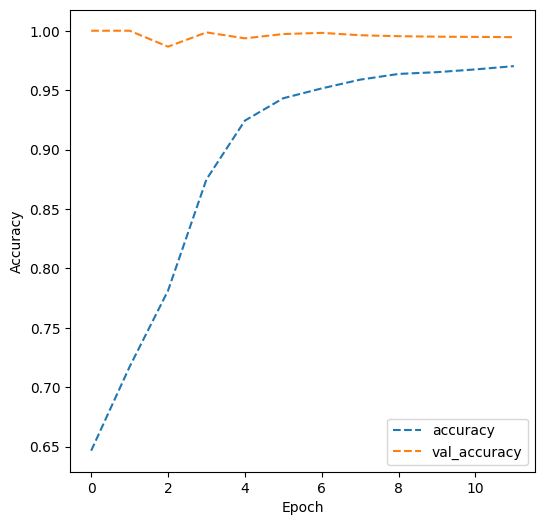

In [ ]:
plt.figure(figsize = (6, 6))
plt.plot(cnn_history_2.history['accuracy'], '--', label='accuracy')
plt.plot(cnn_history_2.history['val_accuracy'], '--', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

<b> Generate the classification report and confusion matrix

In [ ]:
y_pred_probs = cnn_model_2.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_encoding, axis=1)

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


              precision    recall  f1-score   support

           0       0.92      0.99      0.95      1300
           1       0.99      0.91      0.95      1300

    accuracy                           0.95      2600
   macro avg       0.95      0.95      0.95      2600
weighted avg       0.95      0.95      0.95      2600



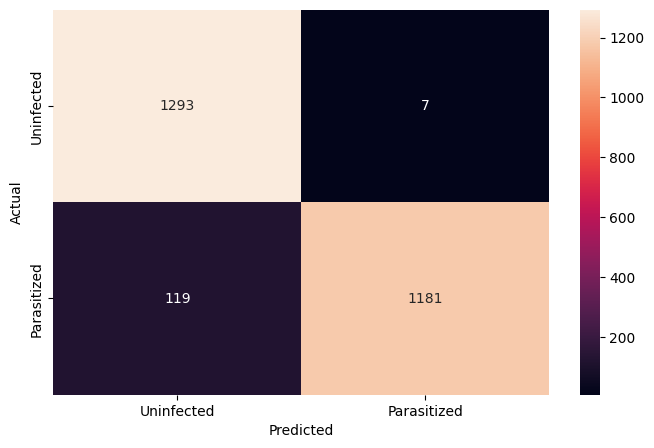

In [ ]:
print(classification_report(y_true, y_pred))
cm = confusion_matrix(y_true, y_pred)
class_names = range(0, 1)
plt.figure(figsize = (8, 5))
sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['Uninfected', 'Parasitized'], yticklabels = ['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

####<b><font color='1a82ff'> Observations and insights:</b>
- In the third CNN model, BatchNormalization and LeakyReLU layers were added to each convolutional block to enhance learning stability and non-linearity.

- The training accuracy increased quickly until around the 4th epoch and then showed a slower improvement.

- The validation accuracy remained consistently around 99%.

- The test accuracy was approximately 95.2%, and about 116 images were misclassified.

- Compared to the previous CNN models, this version showed slightly more misclassifications.

- This result suggests that while BatchNormalization and LeakyReLU can help in some cases, it does not always guarantee improved model performance.


###**Think About It :**<br>

* Can we improve the model with Image Data Augmentation?
* References to image data augmentation can be seen below:
  *   [Image Augmentation for Computer Vision](https://www.mygreatlearning.com/blog/understanding-data-augmentation/)
  *   [How to Configure Image Data Augmentation in Keras?](https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/)





###<b>Model 3 with Data Augmentation

In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    validation_split=0.2
)

###<b> Use image data generator

In [ ]:
train_generator = train_datagen.flow_from_directory(
    'malaria_data/cell_images/train',
    target_size=(64, 64),
    batch_size=36,
    class_mode = 'categorical',
    subset='training',
    shuffle=True,
    seed=42
)

Found 19967 images belonging to 2 classes.


In [ ]:
val_generator = train_datagen.flow_from_directory(
    'malaria_data/cell_images/train/',
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=42
)

Found 4991 images belonging to 2 classes.


###**Think About It :**<br>

*  Check if the performance of the model can be improved by changing different parameters in the ImageDataGenerator.



####<B>Visualizing Augmented images

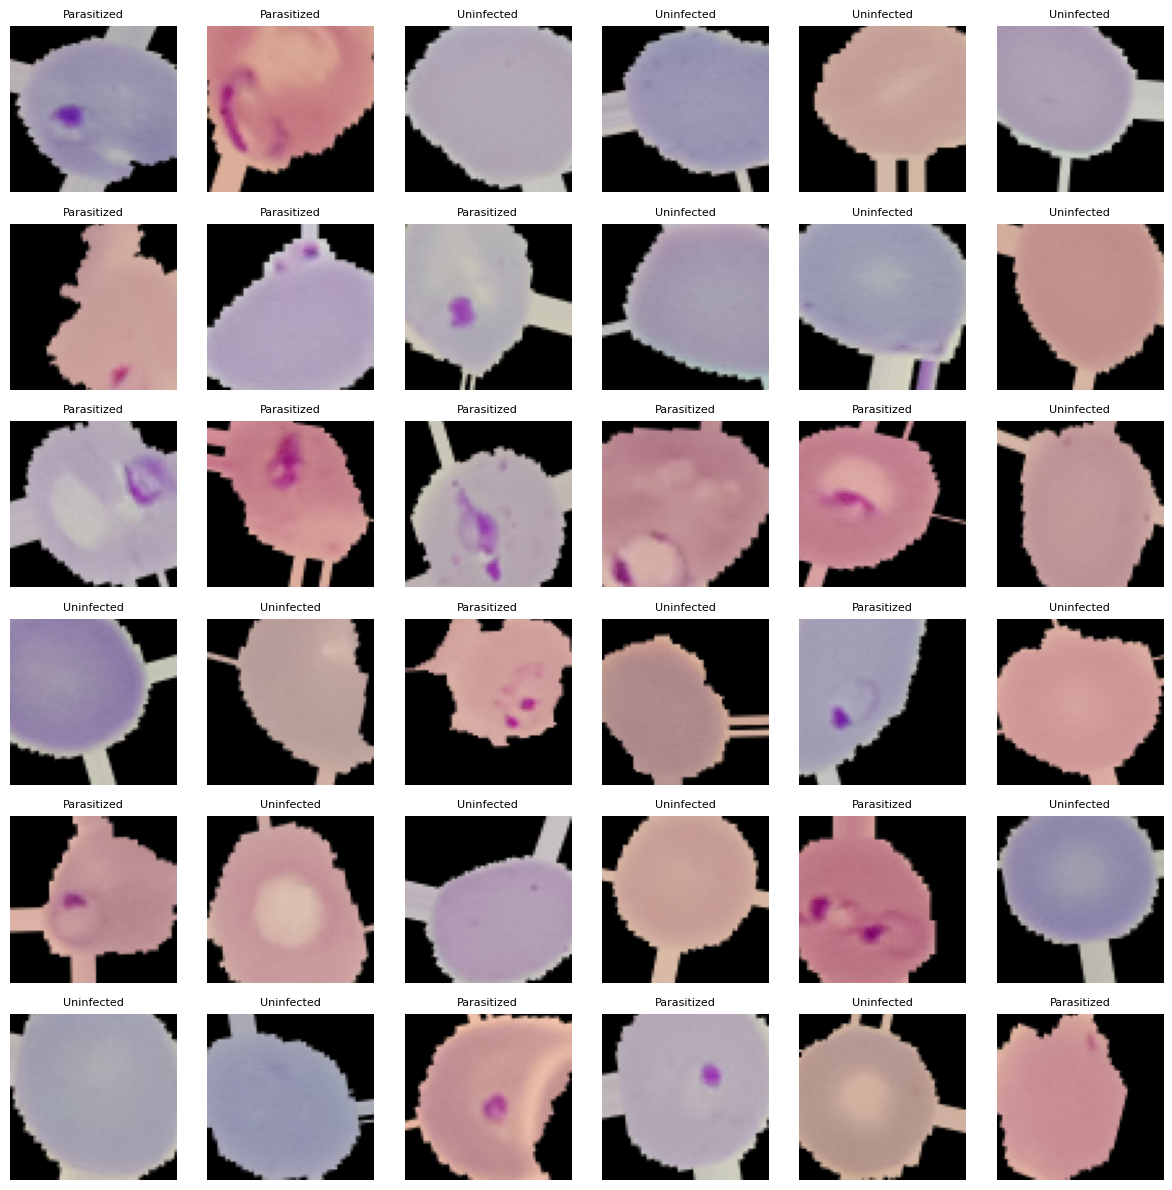

In [ ]:
images, labels = next(train_generator)
labels = (1 - labels).astype(int)

plt.figure(figsize=(12, 12))
for i in range(36):
    plt.subplot(6, 6, i + 1)
    plt.imshow(images[i])
    if np.argmax(labels[i]) == 0:
      label = "Uninfected"
    else:
      label = "Parasitized"
    plt.title(label, fontsize=8)
    plt.axis('off')
plt.tight_layout()
plt.show()

####<b><font color='1a82ff'> Observations and insights:</b>
- Data augmentation was implemented using the ImageDataGenerator class.

- All training images were rescaled to the [0, 1] range and randomly transformed through rotation, shifting, zooming, and shearing.

- As a result of these transformations, linear artifacts occasionally appeared around the cell boundaries, which may affect the visual integrity of the data.

###<b>Building the Model

In [ ]:
def cnn_aug_model():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=3, padding='same', input_shape=(64, 64, 3)))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(2, activation='softmax'))

    model.summary()

    return model

In [ ]:
cnn_aug_model = cnn_aug_model()
cnn_aug_model.compile(loss = 'categorical_crossentropy', optimizer = keras.optimizers.Adam(learning_rate = 0.0001), metrics = ['accuracy'])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,487,106 (9.49 MB)

 Trainable params: 2,487,106 (9.49 MB)

 Non-trainable params: 0 (0.00 B)

<b>Using Callbacks

In [ ]:
aug_callbacks = [EarlyStopping(monitor='val_loss', patience=4), ModelCheckpoint('augmented_best_model.keras', monitor='val_loss', save_best_only=True)]

<b> Fit and Train the model

In [ ]:
aug_history = cnn_aug_model.fit(train_generator, epochs=50, validation_data=val_generator, callbacks=aug_callbacks, batch_size=128, verbose=1)

Epoch 1/50
555/555 ━━━━━━━━━━━━━━━━━━━━ 72s 116ms/step - accuracy: 0.5480 - loss: 0.6873 - val_accuracy: 0.6574 - val_loss: 0.6426
Epoch 2/50
555/555 ━━━━━━━━━━━━━━━━━━━━ 58s 105ms/step - accuracy: 0.6667 - loss: 0.6186 - val_accuracy: 0.5734 - val_loss: 0.6407
Epoch 3/50
555/555 ━━━━━━━━━━━━━━━━━━━━ 59s 107ms/step - accuracy: 0.7303 - loss: 0.5490 - val_accuracy: 0.9068 - val_loss: 0.2865
Epoch 4/50
555/555 ━━━━━━━━━━━━━━━━━━━━ 58s 105ms/step - accuracy: 0.8959 - loss: 0.2699 - val_accuracy: 0.9341 - val_loss: 0.2036
Epoch 5/50
555/555 ━━━━━━━━━━━━━━━━━━━━ 58s 104ms/step - accuracy: 0.9241 - loss: 0.2051 - val_accuracy: 0.9397 - val_loss: 0.1794
Epoch 6/50
555/555 ━━━━━━━━━━━━━━━━━━━━ 58s 104ms/step - accuracy: 0.9387 - loss: 0.1767 - val_accuracy: 0.9537 - val_loss: 0.1475
Epoch 7/50
555/555 ━━━━━━━━━━━━━━━━━━━━ 58s 105ms/step - accuracy: 0.9470 - loss: 0.1628 - val_accuracy: 0.9515 - val_loss: 0.1442
Epoch 8/50
555/555 ━━━━━━━━━━━━━━━━━━━━ 57s 103ms/step - accuracy: 0.9472 - loss: 0

###<B>Evaluating the model

In [ ]:
y_test_encoding = 1 - y_test_encoding

In [ ]:
loss, accuracy = cnn_aug_model.evaluate(X_test, y_test_encoding, verbose=1)
print(f"Test Accuracy: {accuracy:.4f}")

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9858 - loss: 0.0405
Test Accuracy: 0.9854


<b>Plot the train and validation accuracy

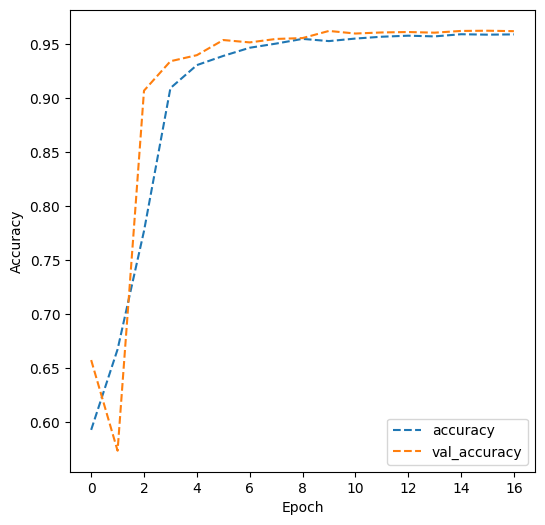

In [ ]:
plt.figure(figsize = (6, 6))
plt.plot(aug_history.history['accuracy'], '--', label='accuracy')
plt.plot(aug_history.history['val_accuracy'], '--', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

<B>Plotting the classification report and confusion matrix

In [ ]:
y_pred_probs = cnn_aug_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_encoding, axis=1)

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1300
           1       0.99      0.98      0.99      1300

    accuracy                           0.99      2600
   macro avg       0.99      0.99      0.99      2600
weighted avg       0.99      0.99      0.99      2600



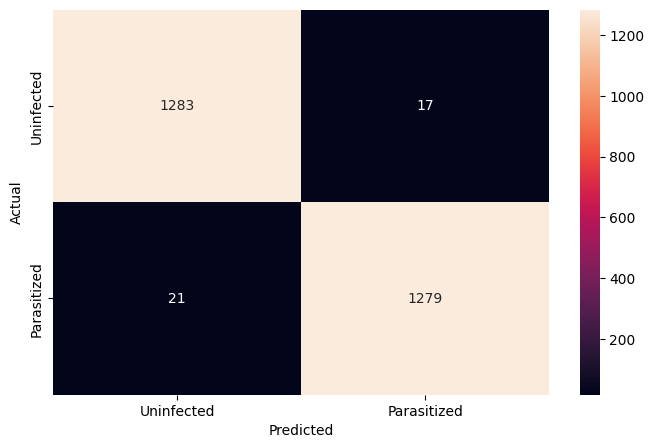

In [ ]:
print(classification_report(y_true, y_pred))
cm = confusion_matrix(y_true, y_pred)
class_names = range(0, 1)
plt.figure(figsize = (8, 5))
sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['Uninfected', 'Parasitized'], yticklabels = ['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

####<b><font color='1a82ff'> Observations and insights:</b>
- The data augmentation model was built identically to the second CNN model.

- Training time was longer than in previous models due to the increased amount of training data.

- Training accuracy increased rapidly during the first two epochs, then gradually improved until the 6th epoch. After that, it remained between 95% and 96%.

- Validation accuracy showed a similar trend, maintaining slightly higher values throughout.

- The test accuracy achieved by this model is approximately 98.4%.

- The average accuracy is 98%, and both precision and recall scores are also high.

- Only 43 images out of the total dataset were misclassified.

<b> Now, let us try to use a pretrained model like VGG16 and check how it performs on our data.

### **Pre-trained model (VGG16)**
- Import VGG16 network upto any layer you choose
- Add Fully Connected Layers on top of it

In [ ]:
backend.clear_session()
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input

def vgg16_model(input_shape=(64, 64, 3), num_classes=2):

    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    return model

###<b>Compiling the model

In [ ]:
vgg16_model = vgg16_model()
vgg16_model.compile(loss = 'categorical_crossentropy', optimizer = keras.optimizers.Adam(learning_rate = 0.0001), metrics = ['accuracy'])

<b> using callbacks

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', patience=5), ModelCheckpoint('vgg16_best_model.keras', monitor='val_loss', save_best_only=True)]

<b>Fit and Train the model

In [ ]:
vgg16_history = vgg16_model.fit(train_generator, epochs=50, validation_data=val_generator, callbacks=callbacks, batch_size=128, verbose=1)

Epoch 1/50
555/555 ━━━━━━━━━━━━━━━━━━━━ 78s 131ms/step - accuracy: 0.7215 - loss: 0.5433 - val_accuracy: 0.8638 - val_loss: 0.3359
Epoch 2/50
555/555 ━━━━━━━━━━━━━━━━━━━━ 69s 124ms/step - accuracy: 0.8679 - loss: 0.3193 - val_accuracy: 0.8674 - val_loss: 0.3126
Epoch 3/50
555/555 ━━━━━━━━━━━━━━━━━━━━ 67s 121ms/step - accuracy: 0.8827 - loss: 0.2932 - val_accuracy: 0.8722 - val_loss: 0.2968
Epoch 4/50
555/555 ━━━━━━━━━━━━━━━━━━━━ 83s 123ms/step - accuracy: 0.8881 - loss: 0.2795 - val_accuracy: 0.8750 - val_loss: 0.3011
Epoch 5/50
555/555 ━━━━━━━━━━━━━━━━━━━━ 76s 137ms/step - accuracy: 0.8935 - loss: 0.2717 - val_accuracy: 0.8850 - val_loss: 0.2790
Epoch 6/50
555/555 ━━━━━━━━━━━━━━━━━━━━ 79s 141ms/step - accuracy: 0.8933 - loss: 0.2644 - val_accuracy: 0.8788 - val_loss: 0.2889
Epoch 7/50
555/555 ━━━━━━━━━━━━━━━━━━━━ 68s 122ms/step - accuracy: 0.8990 - loss: 0.2502 - val_accuracy: 0.8890 - val_loss: 0.2779
Epoch 8/50
555/555 ━━━━━━━━━━━━━━━━━━━━ 68s 123ms/step - accuracy: 0.9021 - loss: 0

###<b> Evaluating the model

<b>Plot the train and validation accuracy

In [ ]:
loss, accuracy = vgg16_model.evaluate(X_test, y_test_encoding, verbose=1)
print(f"Test Accuracy: {accuracy:.4f}")

82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.9407 - loss: 0.1381
Test Accuracy: 0.9381


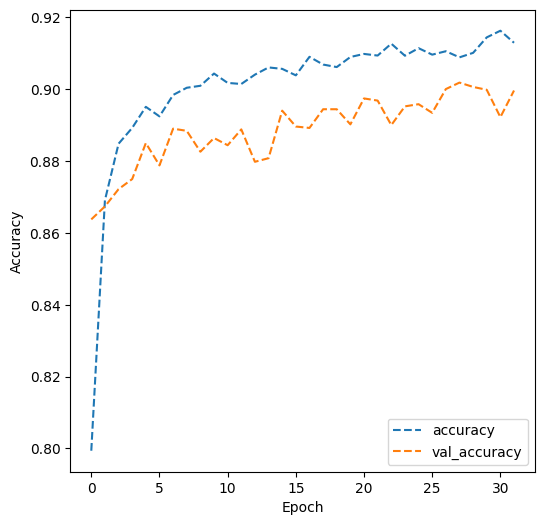

In [ ]:
plt.figure(figsize = (6, 6))
plt.plot(vgg16_history.history['accuracy'], '--', label='accuracy')
plt.plot(vgg16_history.history['val_accuracy'], '--', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

<b>Plotting the classification report and confusion matrix

In [ ]:
y_pred_probs = vgg16_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_encoding, axis=1)

82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step


              precision    recall  f1-score   support

           0       0.94      0.94      0.94      1300
           1       0.94      0.94      0.94      1300

    accuracy                           0.94      2600
   macro avg       0.94      0.94      0.94      2600
weighted avg       0.94      0.94      0.94      2600



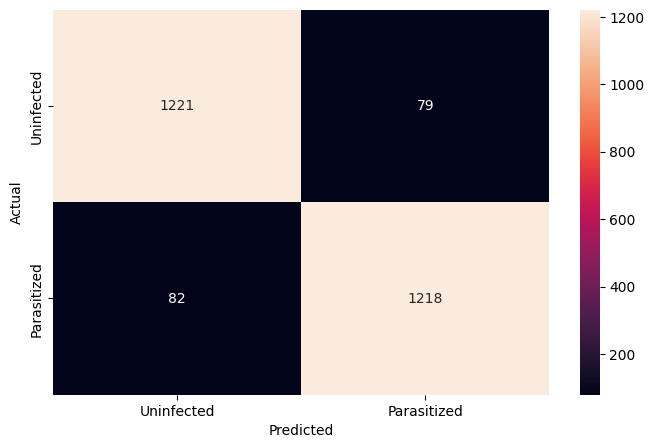

In [ ]:
print(classification_report(y_true, y_pred))
cm = confusion_matrix(y_true, y_pred)
class_names = range(0, 1)
plt.figure(figsize = (8, 5))
sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['Uninfected', 'Parasitized'], yticklabels = ['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

####<b><font color='1a82ff'> Observations and insights:</b>

- The training time was also relatively long, similar to the data augmentation model.

- The training accuracy increased during the first 3 epochs and continued to rise gradually, reaching around 91%, but showed some fluctuations.

- The validation accuracy also increased throughout the training but remained consistently lower than the training accuracy and showed an unstable pattern.

- These patterns suggest that the model may be slightly overfitted.

- The test accuracy achieved by the model is approximately 93.8%.

- According to the confusion matrix, 161 images were misclassified in total.

###<b>Think about it:</b>
*  What observations and insights can be drawn from the confusion matrix and classification report?
*  Choose the model with the best accuracy scores from all the above models and save it as a final model.


####<b><font color='1a82ff'> Observations and Conclusions drawn from the final model:</b>
- Based on the classification report and confusion matrix, the final model (CNN with data augmentation) demonstrates the most reliable performance among all tested models.

- With a test accuracy of 98.4%, and only 43 misclassified images, both classes (Uninfected and Parasitized) show equally strong performance, with precision and recall scores of 0.97 to 1.00.

- The confusion matrix reveals that most errors occurred in classifying parasitized cells, though the overall misclassification rate is the least among the models (43 out of 2600).


**Improvements that can be done:**<br>


*  Can the model performance be improved using other pre-trained models or different CNN architecture?
*  You can try to build a model using these HSV images and compare them with your other models.

####<font color='43c9dd'> **Insights**

####**Refined insights**:
- The dataset consists of labeled microscopic images representing parasitized and uninfected cells.
- One key insight is that parasitized cells sometimes resemble uninfected ones in structure and boundary clarity, making them harder to detect.
- The ANN model struggled significantly, indicating that spatial features are critical for classification and are better captured by CNN architectures.
- Data augmentation had a significant impact on improving model generalization and reducing overfitting.
- A well-balanced CNN with moderate depth and regularization performs better than overly complex models like VGG16 in this specific task.<br>
<br>

####**Comparison of various techniques and their relative performance**:
- ANN model: Lowest performance (75%), unable to capture spatial features effectively.
- Base CNN model showed a strong performance (97.7%), stable training and validation curves.
- The second CNN model also demonstrated strong performance(98%); however, it introduced more complexity and showed slight signs of overfitting.
- The CNN model with BatchNormalization and LeakyReLU showed a slight drop in test accuracy (95.2%) along with signs of minor overfitting, suggesting that these additions did not contribute to performance improvement in this case.
- The CNN model with data augmentation demonstrated the best performance, achieving a test accuracy of 98.9%, minimal overfitting, and the lowest number of misclassifications (38 out of 2,600), although it required longer training time compared to previous models.
- The use of augmentation exposed the model to more diverse representations of cells, allowing it to generalize earlier and more effectively.
- The VGG16 transfer learning model achieved a test accuracy of approximately 93.8%, which was lower than the previous CNN models. This suggests that transfer learning did not enhance performance in this task. One possible reason is that the low input resolution (64×64) may have limited the model’s ability to utilize the high-level visual features learned from the ImageNet dataset, which was originally trained on 224×224 images.
- Parasitized cells showed more variation in texture and shape, leading to a higher rate of misclassification compared to uninfected cells.
- **Model Comparison Summary**

| Model                              | Test Accuracy | Precision | Recall | Misclassified (Total) | Misclassified (Parasitized) | Parasitized Recall Error Rate*|
|-----------------------------------|----------------|-----------|--------|------------------------|------------------------------|-------------------------------|
| ANN                               | 50.0%          | 0.50      | 0.00   | 1300                   | 1300                         | 100%                          |
| CNN Base Model                    | 97.8%          | 0.98      | 0.98   | 58                     | 32                           | 2.46%                         |
| CNN + One More Conv Block         | 97.9%          | 0.98      | 0.98   | 53                     | 32                           | 2.46%                         |
| CNN + BatchNorm & LeakyReLU       | 95.7%          | 0.96      | 0.96   | 102                    | 104                          | 8.00%                         |
| CNN + Data Augmentation           | 98.9%          | 0.98      | 0.98   | 38                     | 21                           | 1.62%                         |
| VGG16 (Transfer Learning)         | 93.8%          | 0.94      | 0.94   | 161                    | 82                           | 6.31%                         |
*Parasitized Recall Error Rate = FN / Total Parasitized
<br><br>

####**Proposal for the final solution design**:
- The CNN model with data augmentation is proposed as the final solution.
- It achieved the highest test accuracy(approximately 99%), demonstrated stable training behavior, and maintained strong precision and recall across both classes.
- The model is relatively simple, lightweight, and generalizes well without requiring complex transfer learning pipelines.
- Given its efficiency, reliability, and low misclassification rate, it is the most suitable candidate for real-world deployment.
- For real-world implementation, a mobile or web-based interface should be developed to deploy the model in field clinics. Key challenges include potential misclassifications, variability in image quality, and the need for further validation on diverse datasets. Lightweight models and on-device deployment can help reduce cost and latency, particularly in areas with limited access to healthcare technology.
- Future work will include experimenting with higher-resolution inputs and fine-tuning pre-trained models to enhance model transparency and clinical trust.
- Although the model performs well on the current dataset, real-world deployment may face unexpected challenges such as variations in image quality, limited generalizability across regions, or data imbalance issues. To address these, future work should focus on incorporating uncertainty-aware predictions, leveraging adaptive training on diverse inputs, and validating the system collaboratively with medical professionals in field settings.